In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariafrenti/age-prediction")

print("Path to dataset files:", path)

100%|██████████| 2.03G/2.03G [00:21<00:00, 100MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mariafrenti/age-prediction/versions/3


In [2]:
from pathlib import Path # Import Path for path manipulation
import os # Make sure os is imported for path operations later

# The 'path' variable is a string from kagglehub.dataset_download.
# We need to convert it to a Path object and join the subdirectories.
image_dir = Path(path) / '20-50' / '20-50'

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
# Use 'int' instead of 'np.int' which is deprecated
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images.head()


,Filepath,Age
0,/root/.cache/kagglehub/datasets/mariafrenti/ag...,23
1,/root/.cache/kagglehub/datasets/mariafrenti/ag...,29
2,/root/.cache/kagglehub/datasets/mariafrenti/ag...,39
3,/root/.cache/kagglehub/datasets/mariafrenti/ag...,36
4,/root/.cache/kagglehub/datasets/mariafrenti/ag...,50


Age: 36


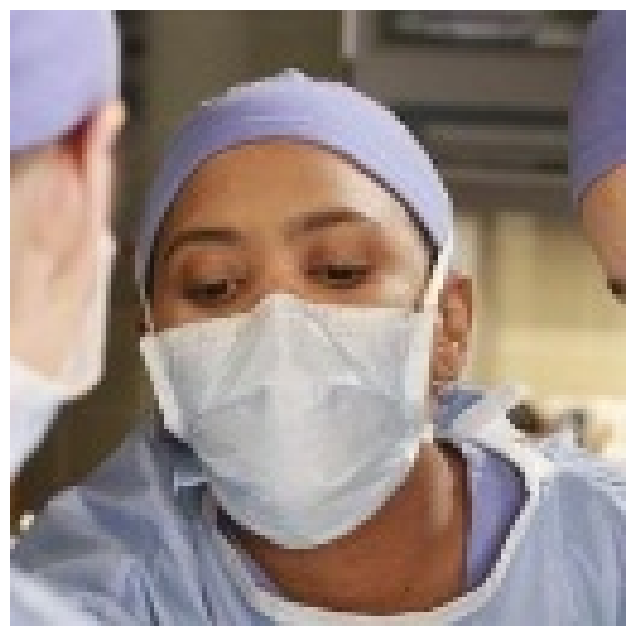

In [3]:
import cv2

def visualize(image):
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = np.random.choice(images.index)
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)


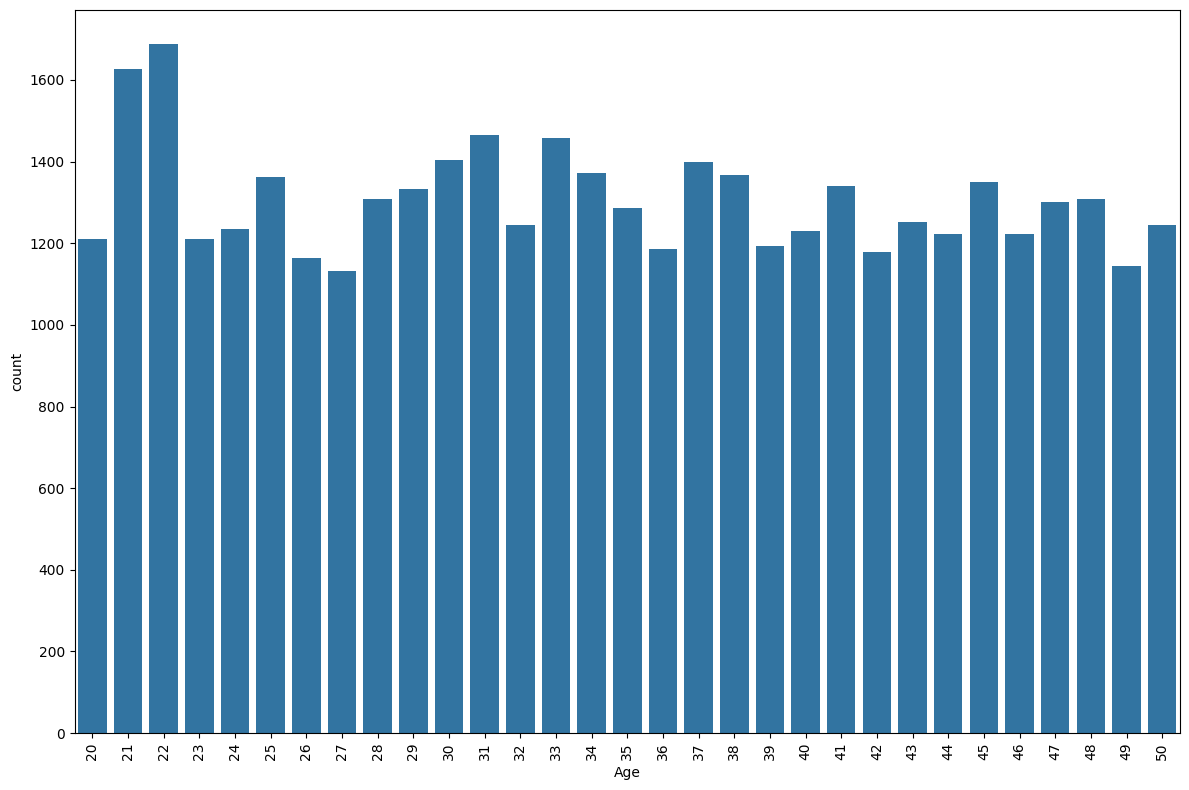

In [4]:
plt.figure(figsize=(12, 8))
sns.countplot(x=images.Age)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [5]:
images.Age = images.Age-20

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset # Added this import

In [8]:
class ImageAgeDataset() :
  def __init__(self , images) :
    self.age = images.Age.values
    self.paths = images.Filepath.values

  def __len__(self) :
    return len(self.age)

  def __getitem__(self , item) :
    out = dict()
    path = self.paths[item]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out


In [9]:

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(images, test_size=0.2, random_state=42)

train_dataset = ImageAgeDataset(train_df)
valid_dataset = ImageAgeDataset(valid_df)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [11]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 96,
            kernel_size = 11,
            stride = 4,
            padding = 50
        )
        self.pool_1 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 96,
            out_channels = 256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )
        self.pool_2 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.conv_3 = nn.Conv2d(
            in_channels = 256,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.conv_4 = nn.Conv2d(
            in_channels = 384,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.conv_5 = nn.Conv2d(
            in_channels = 384,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.pool_3 = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        )
        self.nn = nn.Sequential(nn.Linear(in_features = 9216, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = self.n_classes),
                               )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1,9216)
        x = self.nn(x)
        return x


In [12]:
#hparams
DEVICE = 'cpu'
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 5
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 8
)
model = AlexNetwork(31)
model.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
from tqdm.notebook import tqdm
import numpy as np
def train_step(model , optimizer , dataloader):
  model.train()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE)
    loss = loss_fn(y_hat , y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  return total_loss/len(dataloader)

def valid_step(model, dataloader):
  model.eval()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y)
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ):
  train_losses = []
  valid_losses = []
  min_valid_loss = np.inf
  patience = 0
  for epoch in range(EPOCHS):
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss :
      patience += 1
    else:
      min_valid_loss = valid_loss
      patience = 0

    if patience > MAX_WAIT :
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break
  return train_losses , valid_losses



In [ ]:
train_losses, valid_losses = main(
    model = model,
    optimizer = optimizer,
    train_dataloader = train_loader,
    valid_dataloader = valid_loader
)


  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 6.29632386075684e+26
valid_loss = 2.926429660603354e+26


  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 3.197978827815779e+26
valid_loss = 5.094014816234491e+26


  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 4.037188865924045e+26
valid_loss = 2.2346205444854427e+27


  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 1.965671178878439e+27
valid_loss = 1.8324392393664355e+27


  0%|          | 0/1011 [00:00<?, ?it/s]

In [1]:
test_dataset = ImageAgeDataset(test)


NameError: name 'ImageAgeDataset' is not defined

In [2]:
id = 38
softmax = nn.Softmax()
y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()):
            return i
true_age = train_dataset[id]['y'].item() + 20
print(f'image {id} is {true_age} years old and is predicted {pred(y_hat_id)+20} years old')
image = cv2.imread(test.iloc[id].Filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)


NameError: name 'nn' is not defined